<a href="https://colab.research.google.com/github/nakamura196/ndl_ocr/blob/main/%E4%BE%8B%EF%BC%88%E3%82%BF%E3%82%A4%E3%83%97%EF%BC%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# rdf:type（rdf:subClassOf）を主対象にしたクエリ例

## セットアップ

In [79]:
# 日本語の文字化け対策
!pip install japanize-matplotlib

import requests
import urllib
import json
import pandas as pd
from pandas import json_normalize

import matplotlib.pyplot as plt
import japanize_matplotlib

endpoint = "https://jpsearch.go.jp/rdf/sparql/"

def execQuery(q, endpoint):
  url = "{}?query={}&format=json&output=json&results=json".format(endpoint, urllib.parse.quote(q))
  r = requests.get(url)
  results = json.loads(r.text)
  return results

def convertSparqlResult2Df(resutls, mappings):
  data = []

  for obj in results["results"]["bindings"]:
    item = {}

    for mapping in mappings:
      label = mapping["label"]
      query_var = mapping["query_var"]
      item[label] = obj[query_var]["value"]

    data.append(item)

  df = json_normalize(data)
  return df

## 「type:記述情報」のアイテム一覧

RDFストアに格納されているすべてのアイテムを取得する

In [80]:
q = """
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX type: <https://jpsearch.go.jp/term/type/>
SELECT ?type (count(?cho) as ?count) WHERE {
	?cho rdf:type/rdfs:subClassOf* ?type . 
  	filter (?type = type:記述情報)
}
GROUP BY ?type
ORDER BY desc(?count)
"""

results = execQuery(q, endpoint)
mappings = [
    {
      "label": "タイプ",
      "query_var" : "type"
    },
    {
      "label": "アイテム数",
      "query_var" : "count"
    }
]

convertSparqlResult2Df(results, mappings)

,タイプ,アイテム数
0,https://jpsearch.go.jp/term/type/記述情報,21965450


# 「type:記述情報」の直下のクラス一覧とそのアイテム数

In [81]:
q = """
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX type: <https://jpsearch.go.jp/term/type/>
SELECT ?label (count(?cho) as ?count) WHERE {
	?cho rdf:type/rdfs:subClassOf* ?type . 
  	?type rdfs:subClassOf type:記述情報; rdfs:label ?label . 
}
GROUP BY ?label
ORDER BY desc(?count)
"""

results = execQuery(q, endpoint)

mappings = [
    {
      "label": "タイプ",
      "query_var" : "label"
    },
    {
      "label": "アイテム数",
      "query_var" : "count"
    }
]

convertSparqlResult2Df(results, mappings)

,タイプ,アイテム数
0,資料・情報,15788672
1,標本,5109547
2,建築・芸術,738552
3,混合資源・コレクション,150341
4,イベント,131916
5,プログラム、ソフトウェア,27291
6,人や組織等の実体に関する情報,662


### Pie Chartの例

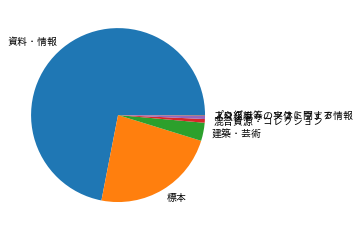

In [82]:
df = convertSparqlResult2Df(results, mappings)
labels = df["タイプ"].tolist()
sections = df["アイテム数"].tolist()
sections = [int(i) for i in sections]
plt.pie(sections, labels=labels)
plt.show()

### 棒グラフの例

Text(0, 0.5, 'type')

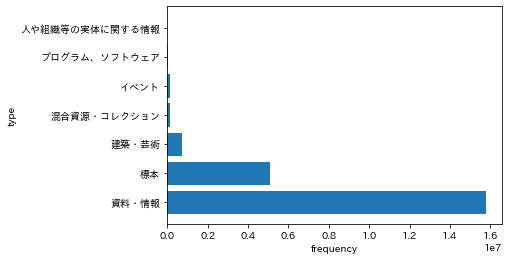

In [83]:
# 棒グラフを表示
plt.barh(labels, sections)
# XとYのラベル
plt.xlabel("frequency")
plt.ylabel("type")

## 「type:記述情報」以下の第1・2階層のクラス一覧とそのアイテム数

In [84]:
q = """
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX type: <https://jpsearch.go.jp/term/type/>
SELECT ?type_lv1 ?type_lv2 (count(?cho) as ?count) WHERE {
	?cho rdf:type/rdfs:subClassOf* ?type_lv2 . 
  	?type_lv2 rdfs:subClassOf ?type_lv1 . 
  	?type_lv1 rdfs:subClassOf type:記述情報
}
GROUP BY ?type_lv1 ?type_lv2
ORDER BY desc(?count)
"""

results = execQuery(q, endpoint)

mappings = [
    {
      "label": "第1階層のタイプ",
      "query_var" : "type_lv1"
    },
    {
      "label": "第2階層のタイプ",
      "query_var" : "type_lv2"
    },
    {
      "label": "アイテム数",
      "query_var" : "count"
    }
]

df = convertSparqlResult2Df(results, mappings)
df

,第1階層のタイプ,第2階層のタイプ,アイテム数
0,https://jpsearch.go.jp/term/type/資料・情報,https://jpsearch.go.jp/term/type/出版物,8593411
1,https://jpsearch.go.jp/term/type/資料・情報,https://jpsearch.go.jp/term/type/文書資料,4938758
2,https://jpsearch.go.jp/term/type/標本,https://jpsearch.go.jp/term/type/動物標本,2586434
3,https://jpsearch.go.jp/term/type/標本,https://jpsearch.go.jp/term/type/植物標本,2388781
4,https://jpsearch.go.jp/term/type/資料・情報,https://jpsearch.go.jp/term/type/資料一般,732666
5,https://jpsearch.go.jp/term/type/建築・芸術,https://jpsearch.go.jp/term/type/芸術・美術,647093
6,https://jpsearch.go.jp/term/type/資料・情報,https://jpsearch.go.jp/term/type/静止画資料,436869
7,https://jpsearch.go.jp/term/type/資料・情報,https://jpsearch.go.jp/term/type/視聴覚資料,418383
8,https://jpsearch.go.jp/term/type/資料・情報,https://jpsearch.go.jp/term/type/構成要素,414756
9,https://jpsearch.go.jp/term/type/資料・情報,https://jpsearch.go.jp/term/type/地図資料,242800


<BarContainer object of 27 artists>

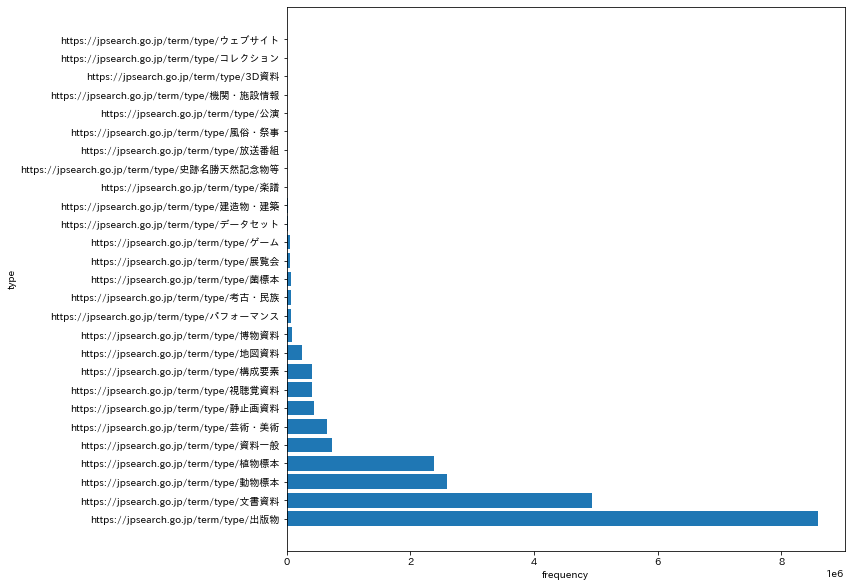

In [85]:
labels = df["第2階層のタイプ"].tolist()
sections = df["アイテム数"].tolist()
sections = [int(i) for i in sections]

# グラフの大きさ指定
plt.figure(figsize=(10, 10))

# XとYのラベル
plt.xlabel("frequency")
plt.ylabel("type")

# 棒グラフを表示
plt.barh(labels, sections)